In [76]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

### Define constants

In [77]:
grid_size_x = 15
grid_size_y = 10
grid_values_count = grid_size_x * grid_size_y
rho_0 = 1.

### Intialize arrays

In [78]:
# arrays defined in format row, column
density_values = np.zeros((grid_size_y, grid_size_x))

# at each position in velocity_values is a vector containing one of the directions as defined in c
velocity_values = np.zeros((grid_size_y, grid_size_x, 2), dtype=np.uint8)

# Velocity directions c (defined by [x,y] components)
c_directions = np.array([
                [ 0, 0], # 0 ()
                [ 1, 0], # 1 (right)
                [ 0, 1], # 2 (up)
                [-1, 0], # 3 (left)
                [ 0,-1], # 4 (down)
                [ 1, 1], # 5 (right-up)
                [-1, 1], # 6 (left-up)
                [-1,-1], # 7 (left-down)
                [ 1,-1]  # 8 (right-down)
             ])

# invert the row values for streaming operation as up is represented by -1 and down by 1
c_directions_for_streaming = c_directions * np.array([1, -1])

# 9 because of 9 velocity directions
initial_density_per_position = rho_0 / float(grid_values_count) 
# evenly distribute density
# f_values = np.full((grid_size_y, grid_size_x, 9), initial_density_per_position / 9.)

# density per position is zero, but only non zero in one specified direction (the value refers to the index in c)
f_values = np.zeros((grid_size_y, grid_size_x, 9))
# f_values[:,:,1] = initial_density_per_position
inital_border_value = np.rint(grid_size_x/2).astype(np.uint8)
f_values[:,inital_border_value :,5] = initial_density_per_position / 2
f_values[:,:inital_border_value,1] = initial_density_per_position / 2


### Functions

##### Density function

In [79]:
def compute_density(y, x):
    return np.sum(f_values[y,x])

In [80]:
def compute_all_densities():
    rows, cols = density_values.shape
    row_indices = np.arange(rows)
    col_indices = np.arange(cols)
    for y in row_indices:
        for x in col_indices:
            density_values[y,x] = compute_density(y,x)
            
# compute_all_densities()

#### Velocity field function

In [81]:
def compute_velocity_field(y,x):

    # TODO: Check if density needs to be stored at all or if only using in formula for new direction
    density = compute_density(y,x)
    density_values[y,x] = density
    # do: [:,np.newaxis] so that broadcasting works
    new_direction = np.sum(f_values[y,x][:,np.newaxis] * c_directions, axis=0) / density
    # numpy rounds 0.5 cases to nearest even value
    x_component, y_component = np.rint(new_direction).astype(np.uint8)

    x_component = 0 if x_component == 0 else (-1 if x_component < 0 else 1)
    y_component = 0 if y_component == 0 else (-1 if y_component < 0 else 1)
    
    # new_direction = np.array([x_component, y_component])
    # # find index of direction in c that resembles the new direction
    # index = np.argwhere((c == new_direction).all(axis=1))[0][0]

    return np.array([x_component, y_component])

In [82]:
def compute_full_velocity_field():
    rows, cols = density_values.shape
    row_indices = np.arange(rows)
    col_indices = np.arange(cols)
    for y in row_indices:
        for x in col_indices:
            velocity_values[y,x] = compute_velocity_field(y,x)

#### Streaming Function

In [83]:
def streaming(): 
    # after_roll = np.roll(test_f_values[:,:,2], shift=(-1,0), axis=(0, 1)) 
    for i in range(len(c_directions)): f_values[:,:,i] = np.roll(f_values[:,:,i], shift=c_directions_for_streaming[i], axis=(1, 0))

# test_f_values = np.random.rand(grid_size_y, grid_size_x, 9)
# values_before = test_f_values.copy()
# streaming()

#### Update function that handles going to next time step

In [84]:
def update():
    streaming()
    compute_full_velocity_field()

### Visualization

#### Density plot

In [85]:
def plot_density_field(compute_velocity_field = False):
    if compute_velocity_field:
        # Compute the velocity field
        compute_full_velocity_field()

    # Create a 3D figure
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Get the shape of the 2D array
    y, x = np.meshgrid(np.arange(density_values.shape[0]), np.arange(density_values.shape[1]), indexing="ij")

    # Plot the surface
    ax.plot_surface(x, y, density_values)

#### Velocity field plot

In [86]:
def plot_velocity_field(timestep = None):
    # define grid of velocity field
    x = np.linspace(0, grid_size_x, grid_size_x)
    y = np.linspace(0, grid_size_y, grid_size_y)
    X, Y = np.meshgrid(x, y)

    fig, ax = plt.subplots()
    U = velocity_values[:,:,0]
    V = velocity_values[:,:,1]
    ax.streamplot(X, Y, U, V)
    # ax.quiver(X, Y, c[velocity_values[:,:], 0], c[velocity_values[:,:]) is also a good option
    ax.set_xticks(np.arange(0, grid_size_x, 1))
    ax.set_yticks(np.arange(0, grid_size_y, 1))
    ax.grid()

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    title = "Velocity field"
    if timestep is not None:
        title += " for t={}".format(timestep)
    ax.set_title(title)

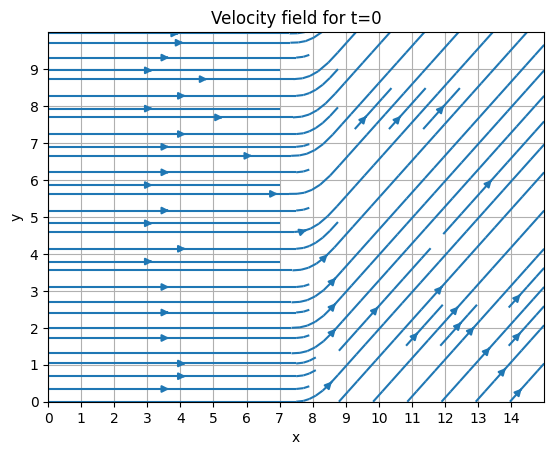

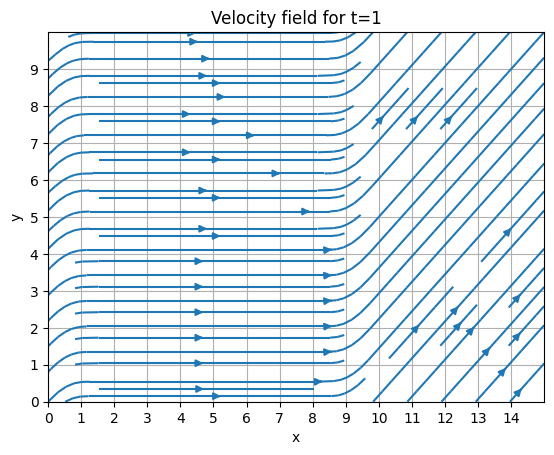

In [87]:
# initial computation of velocity field for visualization
compute_full_velocity_field()
plot_velocity_field(0)

# do a timestep update and plot
update()
plot_velocity_field(1)